[LinkedIn](https://www.linkedin.com/in/gabriel-gregon/)

# <font color = '#2C2C54'> Classificador para Predição de Churn </font>

<div style = "height: 3px; width:100%; background-color:#2C2C54;"></div>

## <font color = '#2C2C54'> Recursos e Ferramentas </font>

Para esse projeto, vamos importar algumas bibliotecas e pacotes para manipular e tratar os dados, plotar gráficos e implementar modelos de ML. A documentação de cada um deles estará disponível logo abaixo.

In [33]:
# Importar bibliotecas e pacotes
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.express    as px

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.preprocessing   import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score,f1_score, roc_auc_score

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## <font color = '#2C2C54'> Análise Exploratória dos Dados </font>

Abaixo, carregamos o arquivo <b><span style='font-family:Consolas'> .csv </span></b> para uma estrutura do tipo `dataframe`. Em seguida, exibimos as primeiras linhas da tabela para nos familiarizarmos com os dados.

In [2]:
# Lê o conjunto de dados e exibe as primeiras linhas.
dados = pd.read_csv('Orange_Telecom_Churn_Data.csv')
dados.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Carregamos um arquivo <b><span style='font-family:Consolas'> .csv </span></b> auxiliar contendo o dicionário de atributos (dicionário de dados), que relaciona o nome de cada atributo (coluna do dataframe) com sua descrição detalhada.

In [3]:
# Carregando arquivo de texto com o dicionário dos atributos
dicionario = pd.read_csv('dicionario_atributos.txt',delimiter=';', index_col='Atributo')

>A passagem do parâmetro `index_col` permite acessar a descrição dos atributos de forma simples usando:
```python
    dicionario.loc[nome_atributo]['Descrição']
```

Antes de partir para a seleção dos atributos (que passa pelo processo de classificá-los em numéricos e categóricos), precisamos ver os tipos seus tipos. Faremos isso usando o método `info()`, que além de exibir os tipos, também fornece outras informações importantes sobre o conjunto de dados.

In [4]:
# Exibe nome, tipo de dado e quantidade de valores nulos para cada atributo.
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   object 
 1   account_length                 5000 non-null   int64  
 2   area_code                      5000 non-null   int64  
 3   phone_number                   5000 non-null   object 
 4   intl_plan                      5000 non-null   object 
 5   voice_mail_plan                5000 non-null   object 
 6   number_vmail_messages          5000 non-null   int64  
 7   total_day_minutes              5000 non-null   float64
 8   total_day_calls                5000 non-null   int64  
 9   total_day_charge               5000 non-null   float64
 10  total_eve_minutes              5000 non-null   float64
 11  total_eve_calls                5000 non-null   int64  
 12  total_eve_charge               5000 non-null   f

> ⚠️ </b>A coluna `Non-Null Count` indica a quantidade de valores nulos para cada atributo. Como não há valores nulos para nenhum atributo, não iremos nos preocupar em realizar qualquer tratamento do tipo.

> ⚠️ </b>Ao analisar os tipos de dados de cada atributo, tenha em mente que, caso haja <b>pelo menos um valor</b> de tipo diferente dos demais, o Python irá classificar os valores desse atributo como `object`. Nesse sentido, sempre que um atributo, por exemplo, for numérico (por definição), mas o atributo `dtypes` indicar como object, é importante verificar a qual(is) é o valor que está contaminando os demais.

### ❓Dados Ausentes, NaN e Tipos Incompatíveis.

Para lidar com dados ausentes, primeiro precisamos saber a porcentagem de dados faltando em uma coluna específica para que possamos escolher uma estratégia apropriada para lidar com a situação. Abaixo, segue uma breve resumo contendo <i>rules of thumb</i>, para lidar com cada caso.

<center>
<img src = '.\Figuras\Analise_Exploratoria-MissingValues.png' width=600>
</center>

> ⚠️ (*) Essa técnica geralmente é preferida, pois os valores ausentes têm uma chance maior de estarem mais próximos da média do que da moda.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Classificando os atributos e analisando suas cardinalidades.
Atributos podem conter valores numéricos (variáveis numéricas) ou não-numéricos (categóricos). Desses, podemos sub-classificá-los em ordinais e não-ordinais. A classificação dos atributos é fundamental para implementação de modelos de ML, pois alguns deles não lidam bem com variáveis categóricas, sendo necessário realizar transformações sobre elas a fim de serem devidamente processadas.

Analisando os primeiros registros da tabela usando o método `.head()` juntamente às informações do dataframe por meio do método `.info()` concluímos que são categóricos os seguintes atributos:

- state
- area_code (*)
- intl_plan
- voice_mail_plan
- churned

> Embora possua tipo numérico, o atributo `area_code` possui cardinalidade baixa (três classes apenas). Além disso, apesar de ser representado por valores numéricos, não há significado intrínseco neles. Sendo assim, atuam como identificadores de uma região, apenas. <br>
<br>
O atributo `churned` é a nossa variável alvo - atributo que contém os rótulos que desejamos predizer. Não deve se realizar nenhum tipo de ação sobre esse atributo.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Codificando variáveis categóricas
Para conseguirmos treinar um classificador, é necessário construírmos as matrizes $X$ e $y$, tais quais possuem valores numéricos e os rótulos a serem preditos, respectivamente. Para isso, precisamos:

- Escolher quais atributos irão compor a matriz $X$
- Para as variáveis categóricas que participarão de $X$, realizar codificações para torná-las numéricas.

Por fim, para um dataset de $n$ linhas e $m$ colunas, devemos ser capazes de ter uma matriz $X_{n,m-1}$ com valores numéricos e um vetor $y$ com os rótulos.

In [5]:
# Descartando os atributos categóricos de alta cardinalidade.
dados.drop(columns={'phone_number','state'}, axis=1, inplace=True)

In [6]:
# Binarização das variáveis categórica de cardinalidade = 2.
lb = LabelBinarizer()

dados['intl_plan'] = lb.fit_transform(dados['intl_plan'])
dados['voice_mail_plan'] = lb.fit_transform(dados['voice_mail_plan'])

A única variável categórica que restou foi `area_code`, que possui três classes (415, 408 e 510). Para ela, iremos aplicar o método `get_dummies()` que cria uma coluna para cada classe do atributo categórico e preenche com 0 ou 1 a depender do registro analisado.

In [7]:
# One-hot-encoding para as variáveis de cardinalidade >=2.
dados = pd.get_dummies(dados, columns=['area_code'])

<div class="alert alert-block alert-success">  
    ✅ Após as ações acima, todos os atributos do dataframe, com excessão do atributo alvo <b>churned</b>, são numéricos.
</div>

In [8]:
dados.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned,area_code_408,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,0,1,0


<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Construindo o modelo base  (Base Model)


Para eliminar o viés de seleção na divisão dos conjuntos de treino e teste, começamos por embaralhar o conjunto de dados.

In [9]:
dados_embaralhados = dados.sample(frac=1, random_state=42)

In [10]:
X = dados_embaralhados.loc[:,dados_embaralhados.columns!='churned'].values
y = dados_embaralhados.loc[:,dados_embaralhados.columns=='churned'].values

In [11]:
# Convertendo a matriz coluna y para um vetor unidimensional
y = y.ravel()

A função `train_test_split` permite indicar a quantidade de registros que serão usados para treino ou teste de diferentes maneiras. No entanto, vamos usar validação cruzada para conseguir obter resultados mais consistentes e garantir que 100% das amostras estão sendo validadas.

```python
X_treino, X_teste, y_treino, y_teste = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=42)
```

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Classificador KNN
A ideia por trás do algoritmo K-Nearest Neighbors(KNN) é muito simples. Para cada registro a ser classificado ou previsto:

1. Encontre $K$ registros que tenham características semelhantes (ou seja, valores de preditores semelhantes).
2. Para classificação, descubra qual é a classe majoritária entre esses registros semelhantes e atribua essa classe ao novo registro.
3. Para previsão (também chamada de regressão KNN), encontre a média entre esses registros semelhantes e faça a previsão usando essa média para o novo registro.


Para criar um classificador KNN, podemos usar o pacote `sklearn.neighbors` e instanciar a classe <b>`KNeighborsClassifier`</b>.<br>
[Documentação completa](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

```python
# Assinatura da função.
class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
```

Antes de criar a instância, vamos analisar como alguns desses parâmetros afetam os passos (1) e (2) mencionados anteriormente.

Os parâmetros `n_neighbors`, `weights`, `p` e `metric` estão intrinsicamente ligados, pois a maneira com qual calculamos a distância entre dois pontos depende de uma série de fatores. Em particular, a noção mais intuitiva que temos quando pensamos em calcular a distância entre dois pontos é tomar a norma L2 (distância euclidiana). 

<center>
<img src = '.\Figuras\KNN_DistanciaEuclidiana.png' width=700>
</center>

Essa intuição produz uma família de circunferências concêntricas a nova amostra. A medida que a circunferência encosta numa amostra próxima, está definida a distância entre essa nova amostra e a vizinha como sendo o raio desta circunferência. (Figura acima)

No entanto, é possível definir outros vizinhos mais próximos se alterarmos alguns parâmetros. Isto é, ao mudarmos a maneira como distâncias estão sendo calculadas, é possível que outro conjunto de vizinhos seja considerado o mais próximo.

Em particular, vamos fixar a métrica `metric` como sendo a de minkowski e variar os demais parâmetros para ver o que acontece.

<center>
<img src = '.\Figuras\KNN_L1eL2.png' width=600>
</center>

> A figura acima ilustra a diferença entre o conjunto de 5 vizinhos mais próximos quando considerado $p=1$ (L1) e $p=2$ (L2)

> Além do parâmetro `p`, também é possível mudar o parâmetro `weights` que atribui pesos diferentes às amostras mais próximas em relação às mais distantes. Em conjuntos desbalanceados (e.g., uma classe figura muito mais do que outra), ajustar esse parâmetro é uma abordagem comum a fim de tentar compensar esse desbalanço.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Pré-Processamento
Antes de treinarmos o classificador e verificar seus primeiros resultados, é importante que todos os atributos estejam com escalas compatíveis. Caso contrário, é possível que um atributo pese muito mais do que outro pelo simples fato de estar num escala menor.

Há algumas maneiras de se ajustar a escala de uma variável. Neste projeto, usaremos o `StandardScaler`, que consiste em tornar levar a média dos atributos para zero e o desvio padrão unitário. O resultado dessa transformação é comumente denominado <b>z-score</b>.

$$
z = {{x-\bar{x}} \over {s}}
$$

In [12]:
# Normalizando os dados da matriz X.
ajuste_escala = StandardScaler()
ajuste_escala.fit(X)
X = ajuste_escala.transform(X)

Vamos treinar o classificador e avaliar sua performance usando validação cruzada (K Fold-Cross)

> O KNN é um algoritmo de aprendizado preguiçoso (lazy learning), o que significa que ele não cria um modelo explícito durante o treinamento. Em vez disso, ele armazena os exemplos de treinamento e calcula as classificações sob demanda quando uma nova instância precisa ser classificada. O desempenho do KNN pode ser afetado pela escolha adequada do valor de K e pela métrica de distância utilizada. Além disso, ele pode ser sensível à escala dos atributos, exigindo, por vezes, a normalização dos dados antes do uso.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Avaliando o desempenho do modelo base
Exibindo a acurácia para diferentes valores de $k$ (hiperparâmetro).

In [13]:
for k in range(1,26,2):

    classificador = KNeighborsClassifier(n_neighbors=k,weights='uniform',p=2)
    scores = cross_val_score(classificador,X,y,cv=10)
    print(k,'%8.1f' % (100*sum(scores)/10))

1     86.8
3     89.4
5     89.1
7     88.8
9     88.6
11     88.3
13     88.0
15     87.8
17     87.7
19     87.6
21     87.7
23     87.6
25     87.5


Os resultados acima exibem uma acurácia máxima de 89,4% para $k=5$. No entanto, é preciso verificar a proporção de True e False para classe rotulada `churned`.

In [14]:
dados['churned'].value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

Repare que a proporção entre clientes que permaneceram na empresa (<font color = 'darkred'>churned</font>=<b><font color='green'>False</b></font>) e clientes que sairam (<font color = 'darkred'>churned</font>=<b><font color='green'>True</b></font>) é extremamente desbalanceada. Em situaçoes como essa, consideramos a acurácia de 85,6% como base. Em outras palavras, para uma acurácia obtida de 89.4%, é difícil quantificar (somente com os números) o aprendizado do modelo.

Mas antes de resolver o problema do conjunto desbalanceado, podemos fazer algumas coisas que, potencialmente, aumentarão essa acurácia, como selecionar atributos relevantes.

### Seleção de atributos

A etapa de seleção de atributos desempenha um papel crucial no processo de construção de modelos de ML e é de grande importância por várias razões. Listaremos, em ordem de importância para <b> este projeto </b>, algumas delas:

<img src = '.\Figuras\sombra.jpg'> 

> A figura acima ilustra como a adição de um atributo aumenta a complexidade do modelo mas, se não houver dados suficientes, o aprendizado pode não ser feito corretamente. Na foto acima, quem se limita pela sombra pode chegar a conclusões erradas sobre o que de fato está acontecendo.

- <b>Melhora o desempenho do modelo</b>: A seleção de atributos pode ajudar a melhorar o desempenho do modelo, uma vez que reduz o ruído e a dimensionalidade desnecessária nos dados. Modelos de ML com menos atributos geralmente têm menor probabilidade de overfitting aos dados de treinamento e podem generalizar melhor para novos dados.
<br>

- <b>Lida com atributos irrelevantes ou redundantes</b>: A seleção de atributos ajuda a lidar com atributos irrelevantes ou redundantes que não contribuem significativamente para a tarefa de modelagem. Isso melhora a qualidade do modelo.<br>
<br>

- <b>Facilita a interpretação</b>: Modelos com menos atributos são mais fáceis de interpretar e explicar. Isso é importante em casos em que a transparência e a compreensão do modelo são cruciais, como na área de saúde ou em questões regulatórias.<br>
<br>

- <b>Reduz o tempo de treinamento</b>: Modelos com menos atributos exigem menos recursos computacionais e tempo de treinamento. Isso é particularmente importante em conjuntos de dados grandes e complexos, onde a seleção de atributos pode acelerar significativamente o processo de treinamento.

Para a selação artesanal dos atributos que participarão do treinamento do modelo, irei utilizar a seguinte métrica: somente atributos cujos valores médios para Churned=True e Churned=False são substancialmente diferentes <sup>(2)</sup>, serão considerados.

In [15]:
# Exibe estatísticas para os atributos numéricos.
dados.groupby('churned').mean().T

churned,False,True
account_length,99.917074,102.332390
intl_plan,0.063825,0.281471
voice_mail_plan,0.284416,0.144272
number_vmail_messages,8.291870,4.496464
total_day_minutes,175.746564,207.870580
total_day_calls,99.899604,100.817539
total_day_charge,29.877494,35.338416
total_eve_minutes,198.805031,211.757850
total_eve_calls,100.241556,99.884017
total_eve_charge,16.898654,17.999562


Da tabela acima, verificamos que os atributos cujas médias estão mais distantes são:
- account_length
- intl_plan
- voice_mail_plan
- number_vmail_messages
- total_day_minutes
- total_day_charge
- total_eve_minutes
- total_night_minutes
- number_customer_service_calls

> <sup>(2)</sup> <b>Substancialmente diferentes</b> é uma forma vaga de falar estatisticamente significantes.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Avaliando o desempenho do modelo com seleção de atributos
Exibindo a acurácia para diferentes valores de $k$ (hiperparâmetro).

In [16]:
# Lista com os atributos (campos da tabela) que farão parte do treinamento.
atributos_selecionados = [
    'account_length',
    'intl_plan',
    'voice_mail_plan',
    'number_vmail_messages',
    'total_day_minutes',
    'total_day_charge',
    'total_eve_minutes',
    'total_night_minutes',
    'number_customer_service_calls',
    'churned']

In [17]:
dados_selecionados = dados[atributos_selecionados]
dados_embaralhados = dados_selecionados.sample(frac=1, random_state=42)

In [18]:
X = dados_embaralhados.loc[:,dados_embaralhados.columns!='churned'].values
y = dados_embaralhados.loc[:,dados_embaralhados.columns=='churned'].values

In [19]:
# Convertendo a matriz coluna y para um vetor unidimensional
y = y.ravel()

In [20]:
# Normalizando os dados da matriz X.
ajuste_escala = StandardScaler()
ajuste_escala.fit(X)
X = ajuste_escala.transform(X)

In [21]:
for k in range(1,26,2):

    classificador = KNeighborsClassifier(n_neighbors=k,weights='uniform',p=2)
    scores = cross_val_score(classificador,X,y,cv=10)
    print(k,'%8.1f' % (100*sum(scores)/10))

1     88.7
3     90.5
5     91.0
7     90.9
9     91.1
11     91.2
13     91.2
15     90.9
17     90.6
19     90.8
21     90.7
23     90.7
25     90.7


Note como obtemos resultados substancialmente melhores simplesmente fazendo a seleção de atributos. Nesse modelo, obtemos uma acurácia máxima de 91.2%.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Matriz de Confusão

Acima, a <b>acurácia</b> foi usada como métrica para avaliar o desempenho do modelo. No entanto, ela não é suficiente para avaliar o desempenho de um modelo - sobretudo em problemas de classes desbalanceadas.

> Exemplo: O dataset considerado possui 85.86% de clientes que não mudaram de serviço, contra 14.14% que trocaram. A acurácia vai medir o total (%) de predições feitas corretamente. No entanto, um modelo que simplesmente prevê que um nova amostra permacenerá com o serviço vai acertar em 85.86% dos casos.

In [22]:
# Segmenta o dataset em conjunto de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, train_size=4000, shuffle=True, random_state=42)

In [23]:
# Treina o classificador e obtem as respostas
classificador = KNeighborsClassifier(n_neighbors=k,weights='uniform',p=2)
classificador.fit(X_teste,y_teste)
y_resposta = classificador.predict(X_teste)

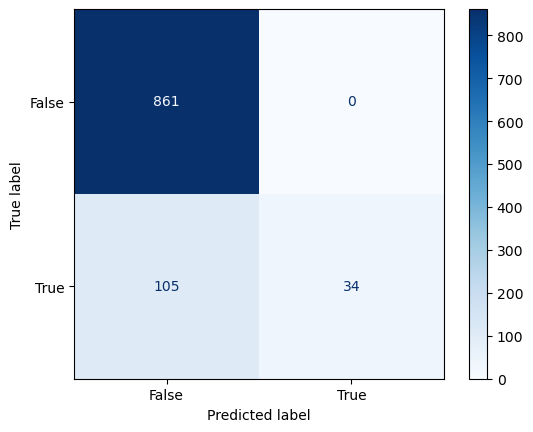

In [24]:
# Exibe a matriz de confusão
matriz_confusao = confusion_matrix(y_teste, y_resposta, labels=classificador.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=classificador.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Acurácia - taxa de acertos
$$
{TP+TN}\over{TP+FN+FP+TN}
$$

In [25]:
# Acurácia
print('%.1f %%' % (100*accuracy_score(y_teste, y_resposta)))

89.5 %


#### Recall - Sensibilidade
"Das amostras realmente positivas, <b> quantas são detectadas como positivas </b>?"

$$
{TP}\over{TP+FN}
$$

In [26]:
# Recall
print('%.1f %%' % (100*recall_score(y_teste, y_resposta)))

24.5 %


Perceba como o Recall nos dá uma informação que a acurácia não dá. Nesse caso, dos 139 clientes que sofreram churn, o modelo detectou apenas 34, produzindo uma taxa igual a 24.5% (baixa).

#### Precisão
"Das amostras preditas como positivas, <b> quantas são de fato positivas </b>?"

$$
{TP}\over{TP+FP}
$$

In [27]:
# Precisão
print('%.1f %%' % (100*precision_score(y_teste, y_resposta)))

100.0 %


Dentre todos os clientes que foram preditos como churned, todos de fato sofreram churned.

#### Especificidade (Sensitividade à classe negativa)
"Das amostras realmente negativas, <b> quantas são detectadas como negativas </b>?"

$$
{TN}\over{FP+TN}
$$

#### F1-Score

O F1 Score é uma métrica de avaliação que combina a precisão (precision) e a revocação (recall) em uma única pontuação. Essa métrica é especialmente útil quando você deseja equilibrar a precisão e a capacidade do modelo em identificar corretamente os casos positivos. O F1 Score é calculado pela fórmula:

$$
F1 = 2 {{Precisão \cdot Recall}\over{Precisão + Recall}}
$$

> <b>F1 Score:</b> O F1 Score é uma pontuação que varia de 0 a 1. Quanto mais próximo de 1, melhor é o desempenho do modelo. Um F1 Score de 1 indica um modelo perfeito que tem uma precisão e recall perfeitas. Um F1 Score de 0 indica um desempenho muito ruim.<br><br>
<b>Balanceamento de Precisão e Recall:</b> O F1 Score é especialmente útil quando você não quer que seu modelo seja tendencioso em direção à precisão ou recall. Por exemplo, em algumas situações, ter muitos falsos negativos (baixa recall) é inaceitável, enquanto em outras situações, muitos falsos positivos (baixa precisão) podem ser prejudiciais. O F1 Score considera ambos os aspectos e fornece uma métrica única que leva em consideração o equilíbrio entre eles.<br><br>
<b>Quando usar o F1 Score</b>: O F1 Score é útil em situações em que a classe positiva é relativamente rara e os falsos positivos e falsos negativos têm implicações significativas. Exemplos incluem detecção de fraudes, diagnóstico médico e detecção de spam. Nessas situações, o F1 Score ajuda a encontrar um compromisso entre minimizar falsos positivos e falsos negativos.<br>

In [28]:
# Score-F1
print('%.1f %%' % (100*f1_score(y_teste, y_resposta)))

39.3 %


Visto (e calculados) as métricas acima, podemos decidir qual delas é um melhor indicador para o nosso problema. Isto é, qual dos dois erros abaixo é mais grave?

- Cliente não sofreu churned (continuou na empresa) e o modelo prevêu que sim.
- Cliente sofreu churned (continuou na empresa) e o modelo prevêu que não.

Repare que o segundo caso é bem pior (falso-negativo), pois o modelo está falhando em detectar aqueles que <b> de fato </b> estão sujeitos a cancelar o serviço. Em outras palavras, é mais importante que o modelo seja sensível (aumento do Recall) do que preciso.

<div style = "height: 5px; width:100%; background-image:linear-gradient(to right, #2C2C54 ,white);"></div>

## Receiver Operating Characteristic (ROC)
ROC é uma métrica de ajuste de limiar móvel.

<center>
<img src = '.\Figuras\ROC_Orange.png' width = 400>
</center>